Complete


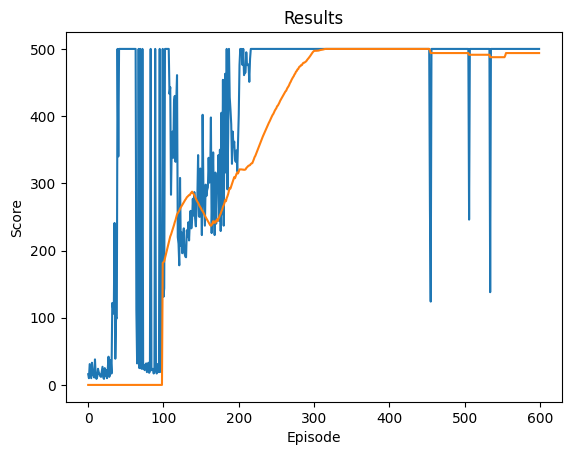

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque, OrderedDict
from itertools import count

import torch
from torch import nn 
import torch.optim as optim
from torch.nn import functional as F

import os
import shutil
import copy

DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_PATH = None

class replay_buffer():
  def __init__(self, capacity):
    self.capacity = capacity
    self.replay_buffer = deque(maxlen=capacity)
    self.longterm_buffer = deque(maxlen=int(capacity * .2))
    self.count = 0

  def push(self, *args):
    #Save early transitions to longterm buffer
    if self.count < self.capacity * .01:
      self.longterm_buffer.append(TRANSITION(*args))
      self.count += 1
    
    if self.count == self.capacity * .1:
      self.count = 0
    
    #save transition to replay buffer
    self.replay_buffer.append(TRANSITION(*args))

  def sample(self, batch_size):
    """
    Samples a random size N minibatch from replay memory
    """
    if len(self.replay_buffer) == self.capacity:
      long_mem_size = int(batch_size / 10)
      batch_size -= long_mem_size
      return random.sample(self.replay_buffer, batch_size) + random.sample(self.replay_buffer, long_mem_size)
    
    return random.sample(self.replay_buffer, batch_size)

  def get_reward_avg(self):
    return torch.mean(torch.stack([x.reward for x in self.replay_buffer]))

  def get_replay_buffer(self):
    return self.replay_buffer
  
  def get_replay_buffer_length(self):
    return len(self.replay_buffer)
  
class DoubleDQN(nn.Module):

  def __init__(self, n_observations, n_actions, arch=(2, 32), drop=False, batch_norm=False):
    super(DoubleDQN, self).__init__()
    self.arch = arch
    self.Q_net = self.build_Q_net(n_observations, n_actions, arch=arch, drop=drop, batch_norm=batch_norm)

  def forward(self, x):
    return self.Q_net(x)

  def build_Q_net(self, n_observations, n_actions, arch , drop, batch_norm):
      """
      Creates arch ammount of fully connected layers
      
      Parameters
      ----------
      arch : tuple(int,int)
        Tuple tuple(int,int) specifying ammount of fully connected layers and neurons per layer
      drop : bool
        Default False, indicating if dropout is wanted
      batch_norm : bool
        Default False, indicating if batch normalization is wanted
      
      """
      layers = []
      cl, lw = arch
      layers.append(nn.Linear(n_observations, lw))
      layers.append(nn.ReLU())
      for _ in range(cl):
        layers.append(nn.Linear(lw, lw))

        if batch_norm: layers.append(nn.BatchNorm1d(lw))
      
        layers.append(nn.ReLU())
        
        if drop: layers.append(nn.Dropout(.5))
      
      layers.append(nn.Linear(lw, n_actions))
      return nn.Sequential(*layers)
  
  def load_params(self):
    global SAVE_PATH
    SAVE_PATH = os.path.dirname(__file__) + f'/data/Checkpoints/DoubleDQN-FC{self.arch[0]}-N{self.arch[1]}'
    if (os.path.exists(SAVE_PATH + '.pt') and os.path.getsize(SAVE_PATH + '.pt') > 0 ):
       #load weights
      print('Previous weights found, loading weights...')
      state_dict = torch.load(SAVE_PATH + '.pt', map_location=DEVICE)
      new_state_dict = OrderedDict()
      for key, value in state_dict.items():
        key = key[6:]
        new_state_dict[key] = value
      self.Q_net.load_state_dict(new_state_dict)
       
      #if loading weights succesdful, make a backup
      shutil.copy(SAVE_PATH + '.pt', SAVE_PATH + 'BackUp.pt')
    else:
      #if no weights are found, create a file to indicate that no weights are found
      with open(SAVE_PATH + '.pt', "w") as f:
        pass


if __name__ == "__main__":
  import gym
  is_ipython = 'inline' in matplotlib.get_backend()
  if is_ipython: from IPython import display
  plt.ion()

  env = gym.make('CartPole-v1')
  
  TRANSITION = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

  # Hyperparameters
  CAPACITY = 10000
  BATCH_SIZE = 128
  CLIPPING = 100
  EPS_START = 0.9
  EPS_END = 0.0001
  EPS_DECAY = 1000
  GAMMA = 0.99
  TAU = 0.005
  LR = 1e-4

  # Get the number of actions and the number of observations
  n_actions = env.action_space.n
  state = env.reset()
  n_observations = len(state)

  # Initialize the networks
  Q_online = DoubleDQN(n_observations=n_observations, n_actions=n_actions, arch=(2, 256)).to(DEVICE)
  Q_target = copy.deepcopy(Q_online).to(DEVICE)


  optimizer = optim.AdamW(Q_online.parameters(), lr=LR, amsgrad=True) 
  replay = replay_buffer(CAPACITY)

  steps_done = 0

  def select_action(state):
    global steps_done
    steps_done += 1
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    if np.random.uniform() > eps_threshold:
      with torch.no_grad():
        return Q_online(state).max(1)[1].view(1, 1)
    else:
      return torch.tensor([[np.random.choice(n_actions)]], device=DEVICE, dtype=torch.long)

  episode_scores = []

  def plot_scores(show_results=False):
    plt.figure(1)
    scores_t = torch.tensor(episode_scores, dtype=torch.float)
    if show_results:
      plt.title('Results')
    else:
      plt.clf()
      plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(scores_t.numpy(), label='Scores')
    # Take 100 episode averages and plot them too
    if len(scores_t) >= 100:
      mean_scores = scores_t.unfold(0, 100, 1).mean(1).view(-1)
      mean_scores = torch.cat((torch.zeros(99), mean_scores))
      plt.plot(mean_scores.numpy(), label='score average')
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
      if not show_results:
        display.display(plt.gcf())
        display.clear_output(wait=True)
      else:
        display.display(plt.gcf())

  def optimize_model():
    if replay.get_replay_buffer_length() < BATCH_SIZE:
      return
    transitions = replay.sample(BATCH_SIZE)
    batch = TRANSITION(*zip(*transitions))

    #get mask of non final states 
    non_done_masks = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=DEVICE, dtype=torch.bool)
    
    #get non final next states
    non_done_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the action already taken
    state_action_values = Q_online(state_batch).gather(dim=1, index=action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=DEVICE)
    with torch.no_grad():
      # Compute V(s_{t+1}) for all next states.
      next_best_actions = Q_online(non_done_next_states).argmax(dim=1).unsqueeze(1)
      next_state_values[non_done_masks] = Q_target(non_done_next_states).gather(dim=1, index=next_best_actions).squeeze(1)

      expected_state_action_values = reward_batch + GAMMA * next_state_values

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(Q_online.parameters(), CLIPPING)
    optimizer.step()


  """Training loop"""
  num_episodes = 600

  for i_episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, device=DEVICE, dtype=torch.float).unsqueeze(0)
    for t in count():
      action = select_action(state)

      next_state, reward, done, _ = env.step(action.item())

      reward = torch.tensor([reward], device=DEVICE, dtype=torch.float)
      if not done:
        next_state = torch.tensor(next_state, device=DEVICE, dtype=torch.float).unsqueeze(0)
      else:
        next_state = None

      replay.push(state, action, reward, next_state)

      state = next_state

      optimize_model()

      Q_target_state_dict = Q_target.state_dict()
      Q_online_state_dict = Q_online.state_dict()
      for key in Q_online_state_dict:
        Q_target_state_dict[key] = TAU * Q_online_state_dict[key] + Q_target_state_dict[key] * (1.0 - TAU)
        Q_target.load_state_dict(Q_target_state_dict)

      if done:
        episode_scores.append(t + 1)
        plot_scores()
        break
  
  print('Complete')
  plot_scores(show_results=True)
  plt.ioff()
  plt.show()
else:
  pass